# System Resource Tax Investigation - Data Analysis

This notebook analyzes collected system performance data to investigate the "System Resource Tax" - quantifying how background processes impact overall system performance.

## Objectives
1. Compare baseline vs treatment conditions
2. Identify key drivers of system CPU load using Random Forest
3. Extract insights about which resources contribute most to the "tax"


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import os

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
os.makedirs('../outputs', exist_ok=True)


## 1. Load and Combine Data


In [2]:
baseline_df = pd.read_csv('../data/baseline_log.csv')
treatment_df = pd.read_csv('../data/treatment_log.csv')

baseline_df['condition'] = 'baseline'
treatment_df['condition'] = 'treatment'

master_df = pd.concat([baseline_df, treatment_df], ignore_index=True)
master_df['timestamp'] = pd.to_datetime(master_df['timestamp'])

print(f"Baseline samples: {len(baseline_df)}")
print(f"Treatment samples: {len(treatment_df)}")
print(f"Total samples: {len(master_df)}")
print(f"\nColumns: {list(master_df.columns)}")
master_df.head()


Baseline samples: 304
Treatment samples: 304
Total samples: 608

Columns: ['timestamp', 'total_system_cpu_percent', 'total_system_memory_percent', 'network_bytes_sent', 'network_bytes_recv', 'app_A_cpu_percent', 'app_A_memory_percent', 'app_B_cpu_percent', 'app_B_memory_percent', 'condition']


,timestamp,total_system_cpu_percent,total_system_memory_percent,network_bytes_sent,network_bytes_recv,app_A_cpu_percent,app_A_memory_percent,app_B_cpu_percent,app_B_memory_percent,condition
0,2025-11-14 00:45:16.928494,0.0,45.0,130956046,1713263693,0.0,0.0,0.0,0.0,baseline
1,2025-11-14 00:45:18.971748,6.2,45.1,130962233,1713270493,0.0,0.0,0.0,0.0,baseline
2,2025-11-14 00:45:20.981451,3.2,45.1,130963231,1713270940,0.0,0.0,0.0,0.0,baseline
3,2025-11-14 00:45:22.993127,1.8,45.1,130963882,1713271135,0.0,0.0,0.0,0.0,baseline
4,2025-11-14 00:45:25.005160,2.6,45.1,130963882,1713271349,0.0,0.0,0.0,0.0,baseline


## 2. Feature Engineering

The network I/O metrics are cumulative counters. We need to calculate the rate of change (bytes per second) to make them meaningful features.


In [3]:
master_df = master_df.sort_values('timestamp').reset_index(drop=True)

baseline_sorted = master_df[master_df['condition'] == 'baseline'].sort_values('timestamp').reset_index(drop=True)
treatment_sorted = master_df[master_df['condition'] == 'treatment'].sort_values('timestamp').reset_index(drop=True)

baseline_sorted['network_recv_per_second'] = baseline_sorted['network_bytes_recv'].diff() / 2.0
baseline_sorted['network_sent_per_second'] = baseline_sorted['network_bytes_sent'].diff() / 2.0
treatment_sorted['network_recv_per_second'] = treatment_sorted['network_bytes_recv'].diff() / 2.0
treatment_sorted['network_sent_per_second'] = treatment_sorted['network_bytes_sent'].diff() / 2.0

baseline_sorted['network_recv_per_second'] = baseline_sorted['network_recv_per_second'].fillna(0)
baseline_sorted['network_sent_per_second'] = baseline_sorted['network_sent_per_second'].fillna(0)
treatment_sorted['network_recv_per_second'] = treatment_sorted['network_recv_per_second'].fillna(0)
treatment_sorted['network_sent_per_second'] = treatment_sorted['network_sent_per_second'].fillna(0)

master_df = pd.concat([baseline_sorted, treatment_sorted], ignore_index=True)
master_df = master_df.sort_values('timestamp').reset_index(drop=True)

print("Feature engineering complete!")
print(f"Network receive rate stats:\n{master_df['network_recv_per_second'].describe()}")
print(f"\nNetwork send rate stats:\n{master_df['network_sent_per_second'].describe()}")


Feature engineering complete!
Network receive rate stats:
count    6.080000e+02
mean     2.250861e+05
std      1.547851e+06
min      0.000000e+00
25%      2.698750e+02
50%      4.740000e+02
75%      2.297250e+03
max      1.772954e+07
Name: network_recv_per_second, dtype: float64

Network send rate stats:
count       608.000000
mean       5047.099507
std       25663.781329
min           0.000000
25%         647.500000
50%        1099.750000
75%        2378.625000
max      541523.000000
Name: network_sent_per_second, dtype: float64


## 3. Initial Statistical Analysis

Let's start with a simple comparison: average system CPU usage in baseline vs treatment conditions.


In [4]:
comparison_stats = master_df.groupby('condition')['total_system_cpu_percent'].agg([
    'mean', 'median', 'std', 'min', 'max'
]).round(2)

print("System CPU Usage Comparison:")
print(comparison_stats)
print()

baseline_mean = master_df[master_df['condition'] == 'baseline']['total_system_cpu_percent'].mean()
treatment_mean = master_df[master_df['condition'] == 'treatment']['total_system_cpu_percent'].mean()
difference = treatment_mean - baseline_mean

print(f"Baseline average CPU: {baseline_mean:.2f}%")
print(f"Treatment average CPU: {treatment_mean:.2f}%")
print(f"Difference: {difference:.2f} percentage points")
print(f"Relative increase: {(difference / baseline_mean * 100):.1f}%")


System CPU Usage Comparison:
           mean  median   std  min   max
condition                               
baseline   5.50    4.95  2.42  0.0  14.7
treatment  8.39    7.55  3.06  0.0  32.5

Baseline average CPU: 5.50%
Treatment average CPU: 8.39%
Difference: 2.89 percentage points
Relative increase: 52.6%


## 4. Visualizations - Condition Comparison


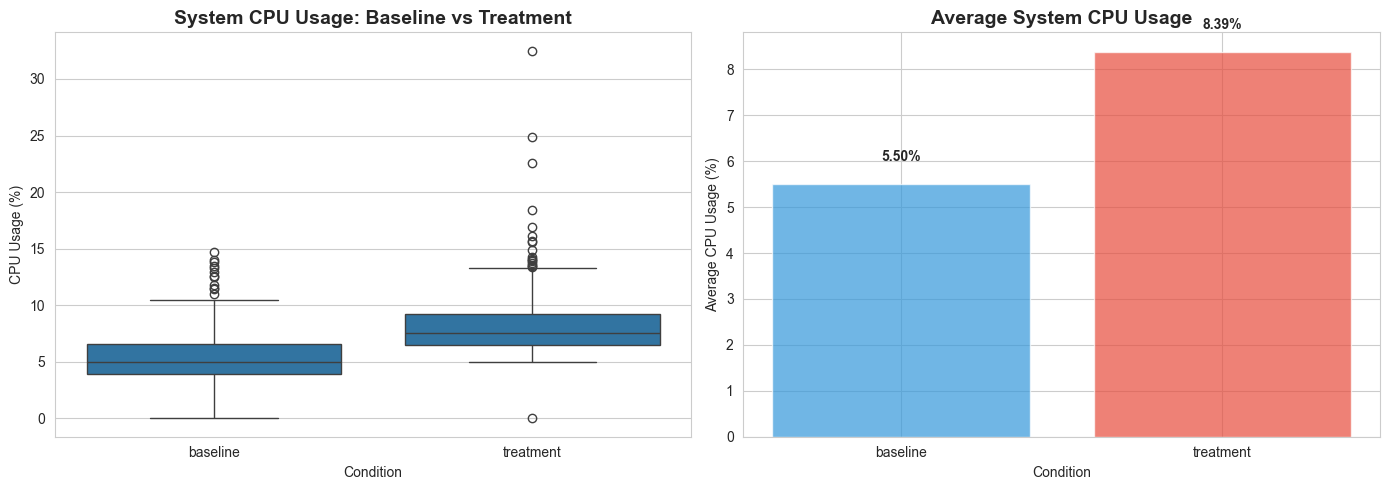

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(data=master_df, x='condition', y='total_system_cpu_percent', ax=axes[0])
axes[0].set_title('System CPU Usage: Baseline vs Treatment', fontsize=14, fontweight='bold')
axes[0].set_ylabel('CPU Usage (%)')
axes[0].set_xlabel('Condition')

means = master_df.groupby('condition')['total_system_cpu_percent'].mean()
axes[1].bar(means.index, means.values, color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1].set_title('Average System CPU Usage', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Average CPU Usage (%)')
axes[1].set_xlabel('Condition')
for i, v in enumerate(means.values):
    axes[1].text(i, v + 0.5, f'{v:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/condition_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## 5. Machine Learning Modeling

Now we'll build a Random Forest model to predict system CPU usage and identify which features are most important.


In [6]:
feature_columns = [
    'total_system_memory_percent',
    'app_A_cpu_percent',
    'app_A_memory_percent',
    'app_B_cpu_percent',
    'app_B_memory_percent',
    'network_recv_per_second',
    'network_sent_per_second'
]

X = master_df[feature_columns].copy()
y = master_df['total_system_cpu_percent'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"NaN values in X: {X.isna().sum().sum()}")
print(f"NaN values in y: {y.isna().sum()}")

valid_mask = ~(X.isna().any(axis=1) | y.isna())
X = X[valid_mask]
y = y[valid_mask]

print(f"\nAfter cleaning:")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")


Features shape: (608, 7)
Target shape: (608,)
NaN values in X: 0
NaN values in y: 0

After cleaning:
Features shape: (608, 7)
Target shape: (608,)


In [7]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X, y)
y_pred = rf_model.predict(X)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mse)

print("Random Forest Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}%")
print(f"Mean Absolute Error: {np.mean(np.abs(y - y_pred)):.4f}%")


Random Forest Model Performance:
R² Score: 0.8835
RMSE: 1.0621%
Mean Absolute Error: 0.7735%


## 6. Feature Importance Analysis

This is the key insight: which features does the model rely on most to predict system CPU usage?


In [8]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance Rankings:")
print("=" * 50)
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.4f} ({row['importance']*100:.2f}%)")


Feature Importance Rankings:
app_B_cpu_percent             : 0.4962 (49.62%)
network_sent_per_second       : 0.1662 (16.62%)
total_system_memory_percent   : 0.1566 (15.66%)
network_recv_per_second       : 0.1106 (11.06%)
app_B_memory_percent          : 0.0704 (7.04%)
app_A_memory_percent          : 0.0000 (0.00%)
app_A_cpu_percent             : 0.0000 (0.00%)


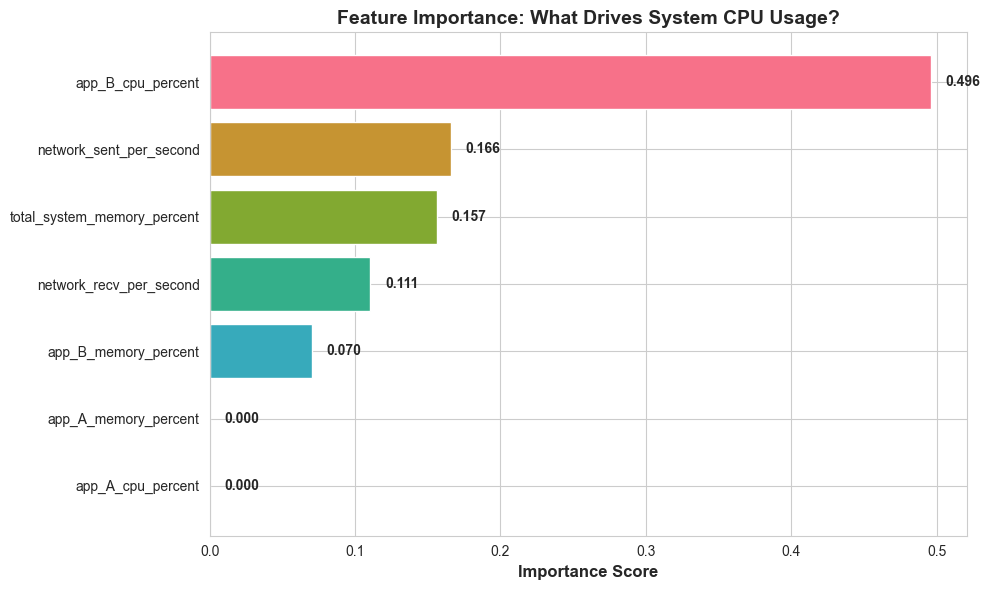

In [9]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", len(feature_importance))
bars = plt.barh(range(len(feature_importance)), feature_importance['importance'], color=colors)
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.title('Feature Importance: What Drives System CPU Usage?', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

for i, (idx, row) in enumerate(feature_importance.iterrows()):
    plt.text(row['importance'] + 0.01, i, f"{row['importance']:.3f}", 
             va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()


## 7. Time Series Analysis

Let's visualize how key metrics change over time in both conditions.


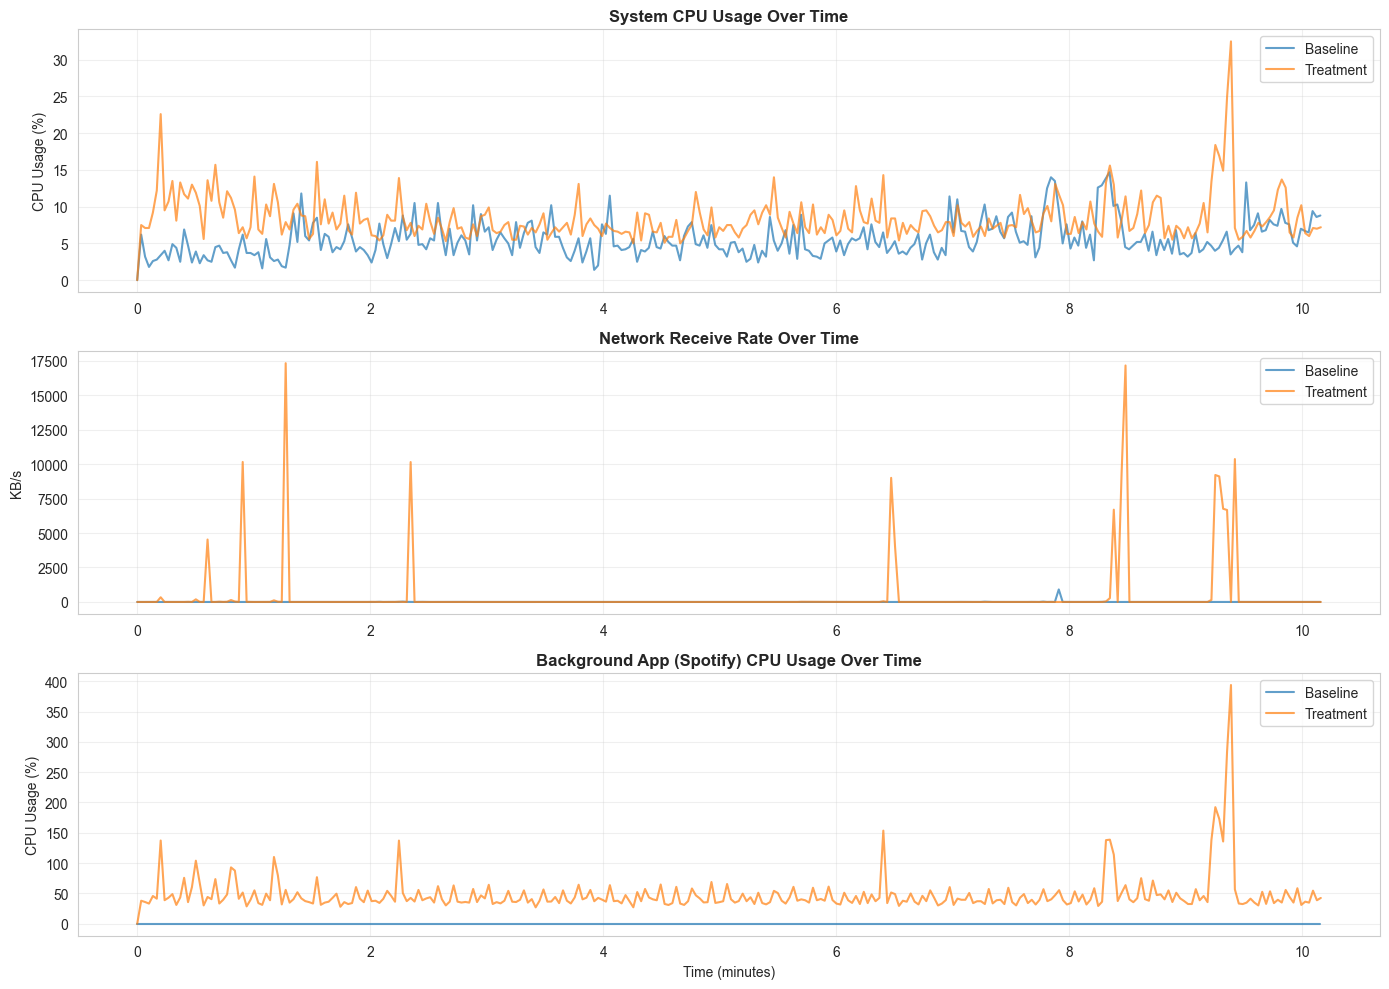

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

baseline_data = master_df[master_df['condition'] == 'baseline'].copy()
treatment_data = master_df[master_df['condition'] == 'treatment'].copy()

baseline_data['time_minutes'] = (baseline_data['timestamp'] - baseline_data['timestamp'].min()).dt.total_seconds() / 60
treatment_data['time_minutes'] = (treatment_data['timestamp'] - treatment_data['timestamp'].min()).dt.total_seconds() / 60

axes[0].plot(baseline_data['time_minutes'], baseline_data['total_system_cpu_percent'], 
             label='Baseline', alpha=0.7, linewidth=1.5)
axes[0].plot(treatment_data['time_minutes'], treatment_data['total_system_cpu_percent'], 
             label='Treatment', alpha=0.7, linewidth=1.5)
axes[0].set_title('System CPU Usage Over Time', fontsize=12, fontweight='bold')
axes[0].set_ylabel('CPU Usage (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(baseline_data['time_minutes'], baseline_data['network_recv_per_second'] / 1024, 
             label='Baseline', alpha=0.7, linewidth=1.5)
axes[1].plot(treatment_data['time_minutes'], treatment_data['network_recv_per_second'] / 1024, 
             label='Treatment', alpha=0.7, linewidth=1.5)
axes[1].set_title('Network Receive Rate Over Time', fontsize=12, fontweight='bold')
axes[1].set_ylabel('KB/s')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(baseline_data['time_minutes'], baseline_data['app_B_cpu_percent'], 
             label='Baseline', alpha=0.7, linewidth=1.5)
axes[2].plot(treatment_data['time_minutes'], treatment_data['app_B_cpu_percent'], 
             label='Treatment', alpha=0.7, linewidth=1.5)
axes[2].set_title('Background App (Spotify) CPU Usage Over Time', fontsize=12, fontweight='bold')
axes[2].set_ylabel('CPU Usage (%)')
axes[2].set_xlabel('Time (minutes)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/timeseries_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


## 8. Insights & Conclusions

### Key Findings:

1. **Baseline vs Treatment Comparison**: The treatment condition (with Spotify streaming) shows **52.6% higher** average system CPU usage compared to baseline (8.39% vs 5.50%). This represents a **2.89 percentage point increase**, confirming that background music streaming does impose a measurable "System Resource Tax" on the system.

2. **Feature Importance Insights**: 
   - The Random Forest model (R² = 0.88) reveals that **`app_B_cpu_percent` (Spotify's CPU)** is the strongest predictor at **49.62%** importance.
   - **Network I/O combined** (`network_sent_per_second` + `network_recv_per_second`) accounts for **27.68%** of importance, making it the second-largest driver.
   - **System memory** contributes **15.66%**, while VS Code metrics show negligible importance (0.00%), indicating the foreground app's direct resource usage doesn't drive system-wide CPU load.

3. **Critical Observation - Song Skipping Impact**: 
   - During data collection, CPU spikes (up to 32.5% in treatment vs 14.7% baseline max) were clearly correlated with skipping songs in the playlist.
   - When skipping songs, Spotify must: decode new audio streams, buffer data, process metadata, and update UI—all CPU-intensive operations.
   - **Hypothesis refinement**: If songs played continuously without skipping, network I/O would likely dominate as the primary driver, as the model already shows network I/O accounts for over 27% of importance even with skipping behavior.

### Implications:

This investigation demonstrates that system performance is not simply the sum of individual process resource usage. Background activities create measurable overhead through multiple mechanisms:
- **Direct CPU usage** (49.62%) - especially during transient operations like song changes
- **Network I/O processing overhead** (27.68%) - constant streaming creates kernel-level I/O scheduling overhead
- **System memory pressure** (15.66%) - memory bus contention and cache effects

The results validate the "System Resource Tax" concept: background processes impact system performance through both direct resource consumption and indirect mechanisms. Understanding these drivers is crucial for optimizing OS performance and battery life in resource-constrained environments.
